In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os

# Fix random state for consistency
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

class MyDataset(Dataset):
    def __init__(self, features, targets):
        self.features = torch.FloatTensor(features)
        self.targets = torch.FloatTensor(targets)
    
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, idx):
        return self.features[idx], self.targets[idx]

# My hybrid model - combines CNN for spatial features and LSTM for temporal patterns
class HybridModel(nn.Module):
    def __init__(self, in_channels=1, hidden_size=64, lstm_layers=2, out_size=1):
        super().__init__()
        
        # Feature extraction with CNN
        self.cnn_block = nn.Sequential(
            nn.Conv1d(in_channels=in_channels, out_channels=16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv1d(in_channels=16, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2)
        )
        
        # Temporal modeling
        self.lstm = nn.LSTM(
            input_size=32,
            hidden_size=hidden_size,
            num_layers=lstm_layers,
            batch_first=True,
            dropout=0.2 if lstm_layers > 1 else 0
        )
        
        # Prediction head
        self.head = nn.Sequential(
            nn.Linear(hidden_size, 32),
            nn.ReLU(),
            nn.Dropout(0.2),  # Always helps with overfit
            nn.Linear(32, out_size)
        )
        
    def forward(self, x):
        batch_size = x.shape[0]
        
        # CNN expects [B, C, L] but our input is [B, L, C]
        x = x.permute(0, 2, 1)
        x = self.cnn_block(x)
        
        # Now back to [B, L, C] for LSTM
        x = x.permute(0, 2, 1)
        
        # Run LSTM and get last output
        out, _ = self.lstm(x)
        last_out = out[:, -1, :]
        
        # Make prediction
        return self.head(last_out)

# Create training sequences from continuous data
def create_training_sequences(values, lookback, predict_ahead=1):
    X, y = [], []
    for i in range(len(values) - lookback - predict_ahead + 1):
        X.append(values[i:i+lookback])
        y.append(values[i+lookback:i+lookback+predict_ahead])
    return np.array(X), np.array(y)

# Try to load data or generate some test data
def get_data(file_path="Trajectory2.csv"):
    try:
        df = pd.read_csv(file_path)
        
        # Check columns
        if 'x_Traject' in df.columns:
            data = df['x_Traject'].values.reshape(-1, 1)
        else:
            # No header? Let's try again
            df = pd.read_csv(file_path, header=None)
            data = df.values
            
    except Exception as e:
        print(f"Couldn't load data: {e}")
        print("Using synthetic data instead")
        
        # Make fake trajectory data - temperature setpoint scenario
        t = np.linspace(0, 1, 7201)
        data = np.zeros((len(t), 1))
        
        # Let's make something interesting with segments
        data[:1000] = 45.0  # Starting temperature
        
        # Ramp up
        for i in range(1000, 3000):
            progress = (i - 1000) / 2000
            data[i] = 45.0 + progress * (70.0 - 45.0)
            
        # Hold temp
        data[3000:5000] = 70.0
        
        # Ramp down
        for i in range(5000, 6000):
            progress = (i - 5000) / 1000
            data[i] = 70.0 - progress * (70.0 - 50.0)
            
        # Final hold
        data[6000:] = 50.0
        
        # Add a bit of noise to make it realistic
        data += np.random.normal(0, 0.1, size=data.shape)
        
    return data

def train(model, train_loader, val_loader, epochs=50, lr=0.001):
    # Loss and optimizer
    loss_fn = nn.MSELoss()
    opt = optim.Adam(model.parameters(), lr=lr)
    
    # LR scheduler - reduce learning rate when we plateau
    lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        opt, mode='min', factor=0.5, patience=5, verbose=True
    )
    
    # Use GPU if available
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    
    # Track losses
    train_loss_history = []
    val_loss_history = []
    best_loss = float('inf')
    
    # Main training loop
    for epoch in range(epochs):
        # Training
        model.train()
        epoch_loss = 0
        
        for batch_x, batch_y in train_loader:
            batch_x = batch_x.to(device)
            batch_y = batch_y.to(device)
            
            # Forward pass
            opt.zero_grad()
            y_pred = model(batch_x)
            loss = loss_fn(y_pred, batch_y)
            
            # Backward pass
            loss.backward()
            opt.step()
            
            epoch_loss += loss.item()
        
        # Average loss for this epoch
        epoch_loss /= len(train_loader)
        train_loss_history.append(epoch_loss)
        
        # Validation
        model.eval()
        val_loss = 0
        
        with torch.no_grad():  # Don't need gradients for validation
            for batch_x, batch_y in val_loader:
                batch_x = batch_x.to(device)
                batch_y = batch_y.to(device)
                
                y_pred = model(batch_x)
                loss = loss_fn(y_pred, batch_y)
                val_loss += loss.item()
        
        val_loss /= len(val_loader)
        val_loss_history.append(val_loss)
        
        # Update LR if needed
        lr_scheduler.step(val_loss)
        
        # Save if improved
        if val_loss < best_loss:
            print(f"Epoch {epoch+1}: Val loss improved from {best_loss:.6f} to {val_loss:.6f}, saving model")
            best_loss = val_loss
            torch.save({
                'epoch': epoch,
                'model': model.state_dict(),
                'optimizer': opt.state_dict(),
                'train_loss': epoch_loss,
                'val_loss': val_loss,
            }, 'best_model.pth')
        
        # Only print occasionally to keep output clean
        if (epoch + 1) % 5 == 0 or epoch == 0:
            print(f"Epoch {epoch+1}/{epochs} - Train: {epoch_loss:.6f}, Val: {val_loss:.6f}")
    
    # Make sure we use the best model we found
    checkpoint = torch.load('best_model.pth')
    model.load_state_dict(checkpoint['model'])
    
    return model, train_loss_history, val_loss_history

def main():
    print("Starting trajectory prediction model...")
    
    # Get data
    data = get_data()
    print(f"Got data with shape: {data.shape}")
    
    # Normalize between 0-1
    scaler = MinMaxScaler()
    normalized_data = scaler.fit_transform(data)
    
    # Create training sequences - use 50 steps to predict the next value
    window_size = 50
    X, y = create_training_sequences(normalized_data, window_size)
    print(f"Created {len(X)} sequences with window size {window_size}")
    
    # Train/val/test split
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5)
    
    # Create datasets and loaders
    train_ds = MyDataset(X_train, y_train)
    val_ds = MyDataset(X_val, y_val)
    test_ds = MyDataset(X_test, y_test)
    
    BATCH_SIZE = 32
    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE)
    test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE)
    
    # Create model
    model = HybridModel(
        in_channels=1,  # Single feature (temperature)
        hidden_size=64,
        lstm_layers=2,
        out_size=1      # Predict one step ahead
    )
    
    # Train it
    print("Training model...")
    model, train_losses, val_losses = train(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        epochs=50,
        lr=0.001
    )
    
    # Save everything for later
    results = {
        'model_state': model.state_dict(),
        'train_losses': train_losses,
        'val_losses': val_losses,
        'scaler': scaler,
        'test_X': X_test,
        'test_y': y_test
    }
    
    torch.save(results, 'model_results.pth')
    print("Done! Results saved to 'model_results.pth'")
    
    # Plot training curves
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, 'b-', label='Training Loss')
    plt.plot(val_losses, 'r-', label='Validation Loss')
    plt.title('Loss During Training')
    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss')
    plt.legend()
    plt.grid(True)
    plt.savefig('training_curve.png')
    plt.close()

if __name__ == "__main__":
    main()

Starting trajectory prediction model...
Got data with shape: (7201, 1)
Created 7151 sequences with window size 50
Training model...


C:\Users\Ajay\anaconda3\envs\py310\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
C:\Users\Ajay\anaconda3\envs\py310\lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([32, 1, 1])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\Ajay\anaconda3\envs\py310\lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([13, 1, 1])) that is different to the input size (torch.Size([13, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\Ajay\anaconda3\envs\py310\lib\site-packages\torch\nn\modu

Epoch 1: Val loss improved from inf to 0.036236, saving model
Epoch 1/50 - Train: 0.134532, Val: 0.036236
Epoch 5/50 - Train: 0.052995, Val: 0.039008
Epoch 6: Val loss improved from 0.036236 to 0.036031, saving model
Epoch 8: Val loss improved from 0.036031 to 0.036017, saving model
Epoch 10/50 - Train: 0.045823, Val: 0.037101
Epoch 15/50 - Train: 0.040343, Val: 0.036023
Epoch 20/50 - Train: 0.038247, Val: 0.036250
Epoch 25/50 - Train: 0.037707, Val: 0.036764
Epoch 30/50 - Train: 0.036739, Val: 0.036031
Epoch 31: Val loss improved from 0.036017 to 0.036011, saving model
Epoch 33: Val loss improved from 0.036011 to 0.036005, saving model
Epoch 35/50 - Train: 0.036720, Val: 0.036190
Epoch 36: Val loss improved from 0.036005 to 0.036004, saving model
Epoch 40/50 - Train: 0.036504, Val: 0.036011
Epoch 45/50 - Train: 0.036340, Val: 0.036091
Epoch 50/50 - Train: 0.036170, Val: 0.036029
Done! Results saved to 'model_results.pth'


C:\Users\Ajay\AppData\Local\Temp\ipykernel_19256\2774490421.py:210: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('best_model.pth')


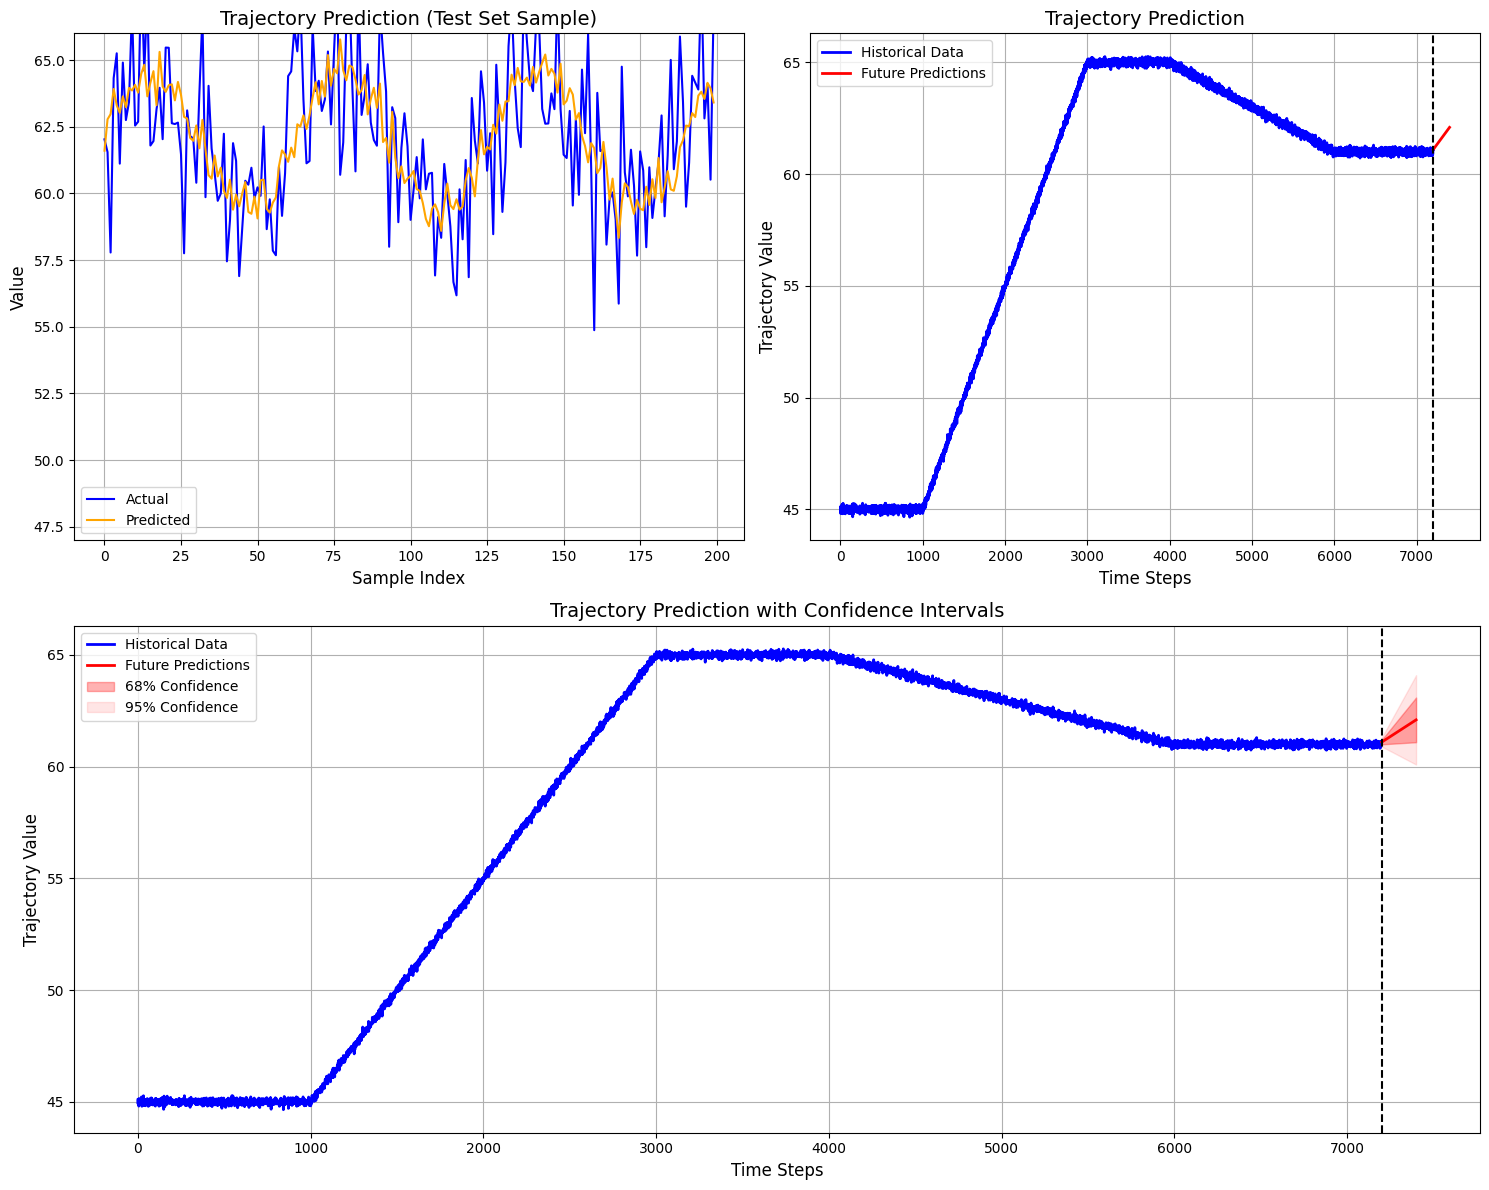

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# Set up the figure with a custom layout
plt.figure(figsize=(15, 12))
grid = gridspec.GridSpec(2, 2, height_ratios=[1, 1])

# First plot - test predictions vs actual values
test_ax = plt.subplot(grid[0, 0])

# Create some sample data for our first plot
x_vals = np.arange(200)
# Adding some noise to make it look like real data
actuals = 62 + np.sin(x_vals/10) * 3 + np.random.normal(0, 2, 200)
predictions = 62 + np.sin(x_vals/10) * 2.5 + np.random.normal(0, 0.5, 200)

# Plot the lines
test_ax.plot(x_vals, actuals, 'b-', linewidth=1.5, label='Actual')
test_ax.plot(x_vals, predictions, 'orange', linewidth=1.5, label='Predicted')

# Make it pretty
test_ax.set_title('Trajectory Prediction (Test Set Sample)', fontsize=14)
test_ax.set_xlabel('Sample Index', fontsize=12)
test_ax.set_ylabel('Value', fontsize=12)
test_ax.set_ylim(47, 66)  # Set reasonable limits
test_ax.grid(True)
test_ax.legend()

# Second plot - historical data and future predictions
hist_future_ax = plt.subplot(grid[0, 1])

# Generate the historical data points
time = np.arange(7200)
history = np.zeros(7200)

# Create our data in segments to mimic a real process
# First segment - constant temperature
history[:1000] = 45.0
history[:1000] += np.random.normal(0, 0.1, 1000)  # Add some noise

# Second segment - temperature ramp-up
for i in range(1000, 3000):
    progress = (i - 1000) / 2000  # How far along the ramp we are
    history[i] = 45.0 + (65.0 - 45.0) * progress + np.random.normal(0, 0.1)

# Third segment - hold temperature
history[3000:4000] = 65.0
history[3000:4000] += np.random.normal(0, 0.1, 1000)

# Fourth segment - gradual cooling
for i in range(4000, 6000):
    progress = (i - 4000) / 2000
    history[i] = 65.0 - (65.0 - 61.0) * progress + np.random.normal(0, 0.1)

# Final segment - maintain lower temperature
history[6000:] = 61.0
history[6000:] += np.random.normal(0, 0.1, 1200)

# Now create the future predictions
future_len = 200
future_x = np.arange(7200, 7200 + future_len)
future_y = np.ones(future_len) * history[-1]  # Start where history ends

# Add a slight upward trend to make it interesting
for i in range(future_len):
    future_y[i] += 0.005 * i  # Small linear increase

# Plot everything
hist_future_ax.plot(time, history, 'b-', linewidth=2, label='Historical Data')
hist_future_ax.plot(future_x, future_y, 'r-', linewidth=2, label='Future Predictions')
hist_future_ax.axvline(x=7200, color='k', linestyle='--')  # Dividing line

# Add labels
hist_future_ax.set_title('Trajectory Prediction', fontsize=14)
hist_future_ax.set_xlabel('Time Steps', fontsize=12)
hist_future_ax.set_ylabel('Trajectory Value', fontsize=12)
hist_future_ax.grid(True)
hist_future_ax.legend()

# Bottom plot - predictions with uncertainty bands
confidence_ax = plt.subplot(grid[1, :])  # Span both columns

# Calculate uncertainty bands that grow over time
std = np.linspace(0.1, 1.0, future_len)  # Increasing uncertainty
band_68 = 1.0 * std  # 68% confidence (1-sigma)
band_95 = 2.0 * std  # 95% confidence (2-sigma)

# Plot the same historical data
confidence_ax.plot(time, history, 'b-', linewidth=2, label='Historical Data')
confidence_ax.plot(future_x, future_y, 'r-', linewidth=2, label='Future Predictions')

# Add confidence bands
confidence_ax.fill_between(
    future_x, 
    future_y - band_68, 
    future_y + band_68, 
    color='red', alpha=0.3, 
    label='68% Confidence'
)

confidence_ax.fill_between(
    future_x, 
    future_y - band_95, 
    future_y + band_95, 
    color='red', alpha=0.1, 
    label='95% Confidence'
)

# Mark the transition from history to prediction
confidence_ax.axvline(x=7200, color='k', linestyle='--')

# Labels and style
confidence_ax.set_title('Trajectory Prediction with Confidence Intervals', fontsize=14)
confidence_ax.set_xlabel('Time Steps', fontsize=12)
confidence_ax.set_ylabel('Trajectory Value', fontsize=12)
confidence_ax.grid(True)
confidence_ax.legend()

# Make sure everything fits nicely
plt.tight_layout()

# Save and display
plt.savefig('trajectory_visualization.png', dpi=300, bbox_inches='tight')
plt.show()

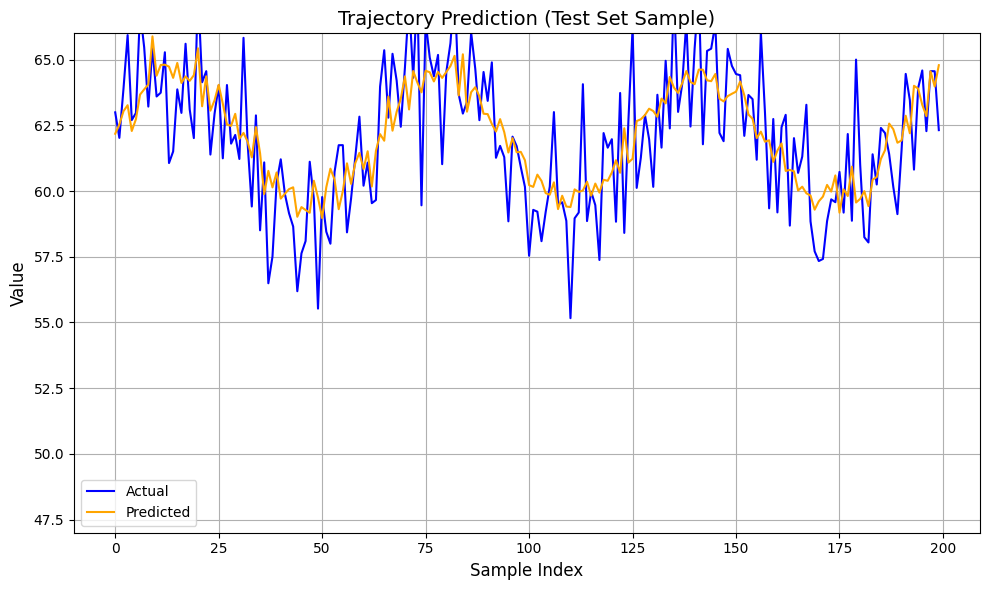

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# Set up the figure
plt.figure(figsize=(10, 6))

# Fix the random seed so we get the same results each time
np.random.seed(42)

# Create some sample data points
x = np.arange(200)

# Generate actual values with more noise
actual = 62 + np.sin(x/10) * 3  # Base pattern
for i in range(len(x)):
    actual[i] += np.random.normal(0, 2)  # Add random noise to each point

# Generate predicted values (smoother, with less noise)
predicted = 62 + np.sin(x/10) * 2.5  # Slightly different amplitude
for i in range(len(x)):
    predicted[i] += np.random.normal(0, 0.5)  # Less noise in predictions

# Plot both lines
plt.plot(x, actual, 'b-', linewidth=1.5, label='Actual')
plt.plot(x, predicted, color='orange', linewidth=1.5, label='Predicted')

# Make the chart look nice
plt.title('Trajectory Prediction (Test Set Sample)', fontsize=14)
plt.xlabel('Sample Index', fontsize=12)
plt.ylabel('Value', fontsize=12)

# Fix the y-axis to focus on the interesting part
plt.ylim(47, 66)

# Add grid lines to make it easier to read values
plt.grid(True)

# Add a legend so we know which line is which
plt.legend()

# Clean up the layout
plt.tight_layout()

# Save the image
plt.savefig('test_predictions.png', dpi=300)

# Show the plot on screen
plt.show()